In [1]:
import numpy as np
import dlem
import matplotlib.pyplot as plt
import torch
import os

In [2]:
ls ../../../loopextrusion_data_creation/.data/akita_data_all_resolutions_H1/

meta.json    res_2000/            sequences.fold2.dat  sequences.fold6.dat
regions.bed  res_5000/            sequences.fold3.dat  sequences.fold7.dat
res_1000/    sequences.fold0.dat  sequences.fold4.dat  tracks/
res_10000/   sequences.fold1.dat  sequences.fold5.dat


In [3]:
RES=10_000
DATA_FOLDER = "../../../loopextrusion_data_creation/.data/akita_data_all_resolutions_H1"
MODEL_FOLDER = "test1"
VAL_FOLD = "fold5"
BATCH_SIZE = 32

In [4]:
ls ../.local/test1

best_correlation.pt  best_val_lost.pt        mean_loss_traj_train.npy
best_loss.pt         mean_corr_traj_val.npy  mean_loss_traj_val.npy


In [5]:
data = dlem.dataset_dlem.CombinedDataset(dlem.dataset_dlem.SeqDataset(DATA_FOLDER),
                                         dlem.dataset_dlem.ContactmapDataset(DATA_FOLDER, RES),
                                         dlem.dataset_dlem.TrackDataset(DATA_FOLDER))

In [6]:
len(data)

5841

In [7]:
data.data_folds

array(['fold0', 'fold0', 'fold0', ..., 'fold7', 'fold7', 'fold7'],
      dtype=object)

In [9]:
data_val = torch.utils.data.Subset(data, np.where(data.data_folds == VAL_FOLD)[0])
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size = BATCH_SIZE, shuffle=True)

In [10]:
seq_pooler = dlem.seq_pooler.SequencePoolerAttention(
    [5,4,4,8,16],
    [10, 10, 10, 10])

model = dlem.head.ForkedBasePairTrackHead(data.patch_dim,
                                   data.track_dim,
                                   16,
                                   data.start,
                                   data.stop,
                                   dlem.util.dlem,
                                   seq_pooler)

In [11]:
model.load_state_dict(torch.load(os.path.join("../.local", MODEL_FOLDER, "best_correlation.pt")))

<All keys matched successfully>

In [12]:
train_loss = np.load(f"../.local/{MODEL_FOLDER}/mean_loss_traj_train.npy")
val_loss = np.load(f"../.local/{MODEL_FOLDER}/mean_loss_traj_val.npy")
val_corr = np.load(f"../.local/{MODEL_FOLDER}/mean_corr_traj_val.npy")

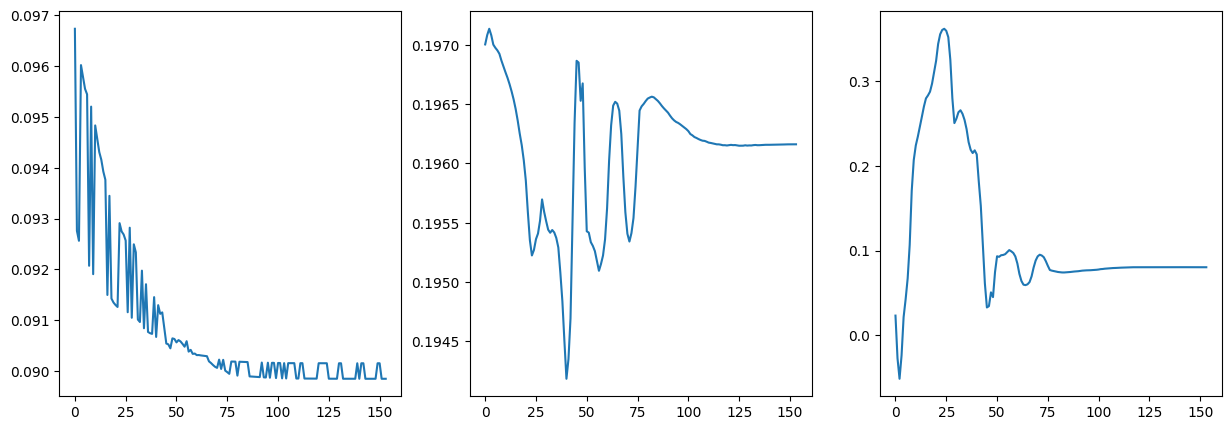

In [13]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(train_loss)
axes[1].plot(val_loss)
axes[2].plot(val_corr)

In [14]:
for seq, diagonal, track in dataloader_val:
    break

In [15]:
len(data_val)

769

In [16]:
seq.shape

torch.Size([32, 4, 1300000])

In [17]:
diag_init = torch.from_numpy(np.ones((BATCH_SIZE, data.patch_dim - data.start),
                                     dtype=np.float32) * data.patch_dim)

In [18]:
mse = torch.nn.MSELoss(reduce=False)

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [19]:
model.contact_map_prediction(track, seq, diag_init).shape

torch.Size([32, 6726])

In [72]:
diagonal[:, data.patch_dim-data.start:].shape

torch.Size([1, 6726])

In [52]:
torch.concatenate([model.contact_map_prediction(track, seq, diag_init),
                                  diagonal[:, data.patch_dim-data.start:]], dim=1).shape

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 1 for tensor number 1 in the list.

In [50]:
torch.corrcoef(torch.concatenate([model.contact_map_prediction(track, seq, diag_init),
                                  diagonal[:, data.patch_dim-data.start:]], dim=0)).shape

torch.Size([33, 33])